In [9]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import xgboost as xgb
import matplotlib.pyplot as plt

from utils import preprocess


In [10]:
def delete_unrelated_feilds(df):
    fields = set(df.keys())
    for k in fields:
        if 'Unnamed' in k:
            df.drop(k, axis=1, inplace=True)
    return df

df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')

df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)

df.to_csv('./data/train_feature.csv')
df_test.to_csv('./data/test_feature.csv')

In [11]:
df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [12]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)
df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)


In [13]:
for t in [df, df_test]:
    for a in class2author:
        t.drop('{}_fasttext_cbow_wide_logi'.format(a), axis=1, inplace=True)
        t.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)
#         t.drop('{}_lstm'.format(a), axis=1, inplace=True)
#         t.drop('{}_word2vec_google_logi'.format(a), axis=1, inplace=True)    

#     df_test.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)        
#     df.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)
#     df_test.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)        
#     df.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
#     df_test.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
# df.drop('num_words'.format(a), axis=1, inplace=True)
    # df_test.drop('num_words'.format(a), axis=1, inplace=True)                
#     t.drop('rate_uniq_chars', axis=1, inplace=True)
#     t.drop('HPL_char_wb_count_NB', axis=1, inplace=True)
#     t.drop('num_words', axis=1, inplace=True)


In [14]:
ite = 5
losses = []
num_split = 5
results = np.zeros((len(df_test), 3))

for i in range(5):
    
    np.random.seed(1234+i)
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.11 #01
    param['max_depth'] = 2
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = 1
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.3 # 0.3
    param['seed'] = 7+i
    num_rounds = 6000

    kf = KFold(n_splits=num_split, shuffle=True, random_state=2017+i)

    for train_ids, val_ids in kf.split(df):
        x_train, x_val = df.loc[train_ids], df.loc[val_ids]
        y_train, y_val = y[train_ids], y[val_ids]

        plst = list(param.items())
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        xgtest = xgb.DMatrix(x_val, label=y_val)

        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=100)

        l = log_loss(y_true=y_val, y_pred=model.predict(xgtest, ntree_limit=model.best_ntree_limit))
        losses.append(l)

        xgtest2 = xgb.DMatrix(df_test)
        results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


[0]	train-mlogloss:0.995325	test-mlogloss:0.995775
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.254079	test-mlogloss:0.267207
[200]	train-mlogloss:0.231712	test-mlogloss:0.260662
[300]	train-mlogloss:0.216454	test-mlogloss:0.25948
[400]	train-mlogloss:0.204224	test-mlogloss:0.258612
[500]	train-mlogloss:0.193194	test-mlogloss:0.260707
Stopping. Best iteration:
[407]	train-mlogloss:0.203478	test-mlogloss:0.258502

[0]	train-mlogloss:0.994912	test-mlogloss:0.995905
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.25213	test-mlogloss:0.277757
[200]	train-mlogloss:0.229993	test-mlogloss:0.271819
[300]	train-mlogloss:0.214274	test-mlogloss:0.270481
[400]	train-mlogloss:0.201438	test-mlogloss:0.270297
[500]	train-mlogloss:0.19002	test-mlogl

[100]	train-mlogloss:0.253494	test-mlogloss:0.273385
[200]	train-mlogloss:0.230602	test-mlogloss:0.266333
[300]	train-mlogloss:0.215108	test-mlogloss:0.266054
[400]	train-mlogloss:0.202404	test-mlogloss:0.266714
Stopping. Best iteration:
[251]	train-mlogloss:0.222071	test-mlogloss:0.265698

[0]	train-mlogloss:0.99136	test-mlogloss:0.991951
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.254184	test-mlogloss:0.272423
[200]	train-mlogloss:0.231727	test-mlogloss:0.265182
[300]	train-mlogloss:0.216681	test-mlogloss:0.264694
[400]	train-mlogloss:0.203736	test-mlogloss:0.264358
Stopping. Best iteration:
[234]	train-mlogloss:0.226088	test-mlogloss:0.264129

[0]	train-mlogloss:0.990346	test-mlogloss:0.99214
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-

In [15]:
losses, np.mean(losses)

([0.25850233691032937,
  0.26999177473710539,
  0.27681713880432079,
  0.2521633001711317,
  0.25445806337103483,
  0.25909584349118797,
  0.25283871017953397,
  0.25228366117296919,
  0.26831468041539325,
  0.2779861719292005,
  0.25441119226592307,
  0.26373803196145579,
  0.26966165150769467,
  0.26580491631972181,
  0.26396320653663352,
  0.265698103841077,
  0.26412921959640018,
  0.26759477834592993,
  0.24566591395700085,
  0.26838228672346037,
  0.25329362772432956,
  0.2675786229484291,
  0.26224774854919009,
  0.25871441456296551,
  0.2709862673338439],
 0.26257286653425049)

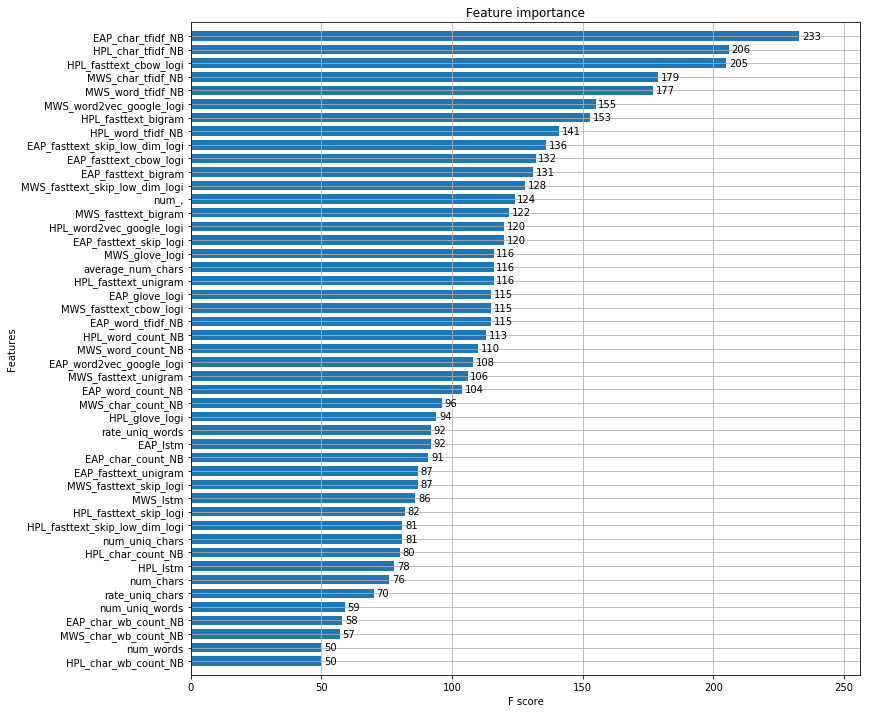

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=100, height=0.7, ax=ax)
plt.show()

In [16]:
submission_df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    submission_df[a] = results[:, i]/num_split/5

with open('./results/5_results.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in submission_df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')